# K-Means clutering technique to find PSD families within the CAMP2Ex field campain dataset

---

## Imports

In [1]:
import xarray as xr
import datatree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.transforms as mtransforms
from xhistogram.xarray import histogram
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from scipy.special import gamma
from dask.distributed import Client, LocalCluster
from matplotlib.colors import ListedColormap

In [2]:
# setting up the Seaborne style including figure  dpi
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set(style='white', font_scale=0.9)
sns.set_style("ticks")

### Local Cluster

Let's spin up our `Dask` local cluster

In [3]:
cluster = LocalCluster()  
# display(cluster)

## Data

CAMP2Ex dataset is stored in Analysis-Ready Cloud-Optimized (ARCO) format ([Abernathey et al. 2021](https://ieeexplore.ieee.org/document/9354557)) using [Xarray-Datatree](https://xarray-datatree.readthedocs.io/en/latest/) data model that allows us to have both Learjet and P3B datasets in one `datatree`. Climate and Forecast [(CF)](https://cfconventions.org/) were used to promote the processing and sharing of files created 

In [4]:
path_data = '../data/camp2ex_dtree.zarr'
dt_camp2ex = datatree.open_datatree(path_data, engine='zarr', consolidated=True, drop_variables=["lwc", "d_d"])

In [5]:
dt_camp2ex

DataTree('None', parent=None)
├── DataTree('Lear')
│       Dimensions:             (time: 4307, diameter: 58)
│       Coordinates:
│         * diameter            (diameter) float64 464B 50.0 60.0 ... 3.824e+03
│         * time                (time) datetime64[ns] 34kB 2019-09-07T00:50:13 ... 20...
│       Data variables: (12/17)
│           Att_ka              (time) float64 34kB ...
│           altitude            (time) float64 34kB ...
│           dbz_t_ka            (time) float64 34kB ...
│           dbz_t_ku            (time) float64 34kB ...
│           dm                  (time) float64 34kB ...
│           dm_rt_dfr_gm_mu_3   (time) float64 34kB ...
│           ...                  ...
│           r                   (time) float64 34kB ...
│           r_dm_gm_mu_3        (time) float64 34kB ...
│           r_gpm_operational   (time) float64 34kB ...
│           sigma               (time) float64 34kB ...
│           temp                (time) float64 34kB ...
│           vert_vel            (time) float64 34kB ...
└── DataTree('P3B')
        Dimensions:             (time: 5146, diameter: 58)
        Coordinates:
          * diameter            (diameter) float64 464B 50.0 60.0 ... 3.824e+03
          * time                (time) datetime64[ns] 41kB 2019-08-24T22:12:20 ... 20...
        Data variables: (12/17)
            Att_ka              (time) float64 41kB ...
            altitude            (time) float64 41kB ...
            dbz_t_ka            (time) float64 41kB ...
            dbz_t_ku            (time) float64 41kB ...
            dm                  (time) float64 41kB ...
            dm_rt_dfr_gm_mu_3   (time) float64 41kB ...
            ...                  ...
            r                   (time) float64 41kB ...
            r_dm_gm_mu_3        (time) float64 41kB ...
            r_gpm_operational   (time) float64 41kB ...
            sigma               (time) float64 41kB ...
            temp                (time) float64 41kB ...
            vert_vel            (time) float64 41kB ...

Lets assing aircraft flag to each dataset. Flag 1 for Learjet and 0 for NASA P3B aircraft

In [6]:
# display(dt_camp2ex['Lear'].ds)
ds_lear = dt_camp2ex['Lear'].ds.copy()
ds_lear['aircraft'] = ('time', np.zeros_like(ds_lear.Att_ka.values))

In [7]:
# display(dt_camp2ex['P3B'].ds)
ds_p3 = dt_camp2ex['P3B'].ds.copy()
ds_p3['aircraft'] = ('time', np.ones_like(ds_p3.Att_ka.values))

Now we can merge both datasets into a single `Xarray.Dataset`

In [8]:
ds = xr.concat([ds_lear.drop_dims('diameter'), ds_p3.drop_dims('diameter')], dim='time')

We discarded data with Liquid Water Content  $(LWC) <=0.05 gm^{-3}$ (Lance et at., 2010, Gupta et al 2021) and took $log_{10}$ of rainfall rate (r), total number concentration (nt) and liquid water content (lwc_cum)

In [9]:
ds = ds.where(ds.lwc_cum > 0.05, drop=True)
ds['logr'] = np.log10(ds.r)
ds['lognt'] = np.log10(ds.nt)
ds['loglwc'] = np.log10(ds.lwc_cum)


Now we converted our `Xarray.Dataset` into a `Panda.Dataframe`

In [10]:
df = ds.to_dataframe().reset_index()

GPM-Analytical solution [(Liao, et al., 2014)](https://journals.ametsoc.org/view/journals/apme/53/11/jamc-d-14-0003.1.xml) assume shape parameter ($\mu$) to be fixed and equal to three. Thus, we can add a new column with this value

In [11]:
df['mu_3']= 3

Following [Williams et al. (2014)](https://journals.ametsoc.org/view/journals/apme/53/5/jamc-d-13-076.1.xml) we can estimate the uncorrelated shape parameter ($\mu_{unc}$) (equations 20 to 26) 

First we can estimate the $b_m$ parameter that allow us to find the closest to zero relationship between $\sigma^ \prime$ and $D_m$

In [12]:
br = np.arange(0.5, 5.5, 0.001)
res = np.zeros_like(br)
for i in range(br.shape[0]):
        res[i] = np.corrcoef(df.dm, df.sigma / df.dm ** br[i])[0, 1] ** 2
    
bm = br[np.argmin(res)]
bm

0.7120000000000002

Now we can add this information to our dataframe

In [13]:
df['sigma_prime'] = df.sigma / (df.dm ** bm)
df['new_sigma'] = df['sigma_prime'].mean() * df['dm'] ** bm
df['mu_unc'] = (df.dm ** (2 - 2 * bm) / (df['sigma_prime'].mean() ** 2)) - 4

## K-means

To apply the cluster analysis, we standardized our input features ($\sigma$,  $D_m$,  $Log_{10}(N_w)$,  $Log_{10}(r)$,  $Log_{10}(N_T)$, and $Log_{10}(LWC)$) by removing the mean and scaling to unit variance using the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from the `Sklearn` Python package as follows

In [14]:
scaler = StandardScaler()
df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]]= scaler.fit_transform(df[['sigma', 'dm', 'log10_nw', 'logr', 'lognt', 'loglwc']])

### K-means clustering benchmarking

As a supervised machine learning technique, K-means clustering requires the number of the cluster to be defined beforehand. To determine the optimal number of clusters (k) for the PSDs, we executed the algorithm for k values ranging from 2 to 15. Using the within-cluster sum of squares (WCSS), also known as the elbow method, Davies-Bouldin index (Davies & Bouldin, 1979), and Silhouette score (Rousseeuw, 1987)

In [15]:
def get_kmeans_score(df, center):
    '''
    returns the elbow inertial index, the Davies Bouldin and Silhouette score
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        elbow inertial index, the Davies Bouldin and Silhouette score
    '''
    kmeans = KMeans(n_clusters=center, random_state=10)
    model = kmeans.fit(df)
    model2 = kmeans.fit_predict(df)
    cluster_labels = model.labels_
    
    dav = davies_bouldin_score(df, model2)
    sil = silhouette_score(df, cluster_labels)
    elbow = model.inertia_
    return dav, sil, elbow

We defined some list to store results of each cluster results for every score. Then we test each number of cluster. 

In [16]:
dav = []
sil = []
elbow = []

for k in range(2,15):
    _dav, _sil, _el = get_kmeans_score(df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]], k)
    dav.append(_dav)
    sil.append(_sil)
    elbow.append(_el)

Now, we can see the score result for different number of clusters.


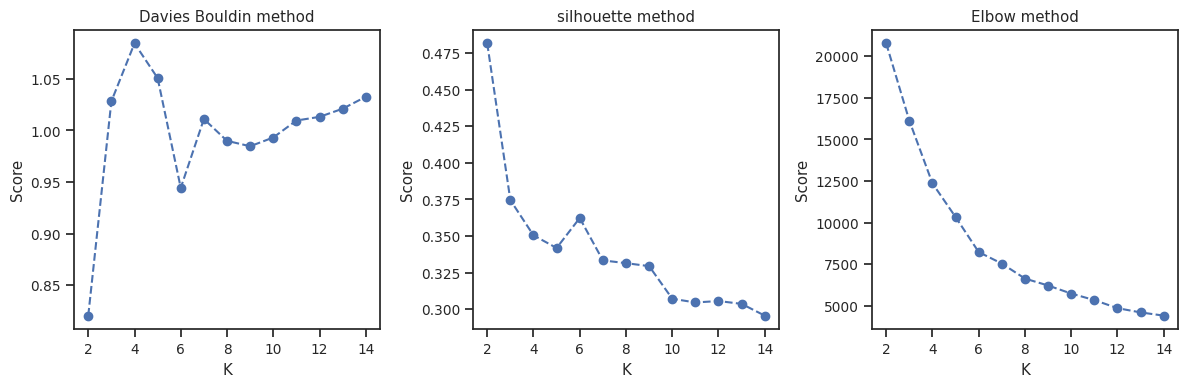

In [17]:
centers = range(2,15)
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4), dpi=100)
ax.plot(centers, dav, linestyle='--', marker='o', color='b');
ax.set_xlabel('K');
ax.set_ylabel('Score');
ax.set_title('Davies Bouldin method');

ax1.plot(centers, sil, linestyle='--', marker='o', color='b');
ax1.set_xlabel('K');
ax1.set_ylabel('Score');
ax1.set_title('silhouette method');

ax2.plot(centers, elbow, linestyle='--', marker='o', color='b');
ax2.set_xlabel('K');
ax2.set_ylabel('Score');
ax2.set_title('Elbow method');
fig.tight_layout()

### K-means clustering with 6 PSD families


Based on the cluster benchmarking, we deduced that k=6 the most suitable number of clusters representing the data.

Let's select scaled/transformed data to reapply the K-means clustering algorithm

In [18]:
X = df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]]

We can now apply the K-means cluster technique using these (X) features

In [19]:
kmeans = KMeans(n_clusters=6, random_state=10)
kmeans.fit(X)

KMeans(n_clusters=6, random_state=10)

Create a new column with the Kmeans labels. We add one to have labales from 1 to 6 (instead of 0 to 5)

In [20]:
df['kmeans_6'] = kmeans.labels_ + 1

Reorder and replace some labels to make them equal to the paper's figure when plotting mean PSDs

In [21]:
df['kmeans'] = df['kmeans_6'].replace([1, 3, 4, 5, 2, 6], 
                                      [1, 2, 3, 4, 5, 6])

Computing Dual Frequency Ratio

In [22]:
df['dfr'] = df['dbz_t_ku'] - df['dbz_t_ka']

We can create a fuunction that computes the Normalized-Gama size distribution

In [23]:
def norm_gamma(d, nw, mu, dm):
    """
    Functions that computes the normalized-gamma size distritubion (Testud et al., 2002)
    Param d: diameter in mm
    Param nw: Normalized intercep parameter
    Param mu: Shape parameter
    Param dm: Mass-weighted mean diameter
    """
    f_mu = (6 * (4 + mu) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4) )
    slope = (4 + mu) / dm
    return nw * f_mu * (d / dm) ** mu * np.exp(-slope * d)

### K-means results 

The scatter plot of Dm and Nw colored by each PSD family is shown below. The mean PSD computed using the mean quantities of each parameter at each group is also displayed. 

Let's define some figure settings, such as colormaps.

In [24]:
# number of clusters
n_c = 6
# defining the Colormap for each cluster identified
my_cmap6 = ListedColormap(sns.color_palette('deep', n_c))
colors6 = my_cmap6(np.linspace(0,1, n_c))

Now we can create scatter and median PSD plots

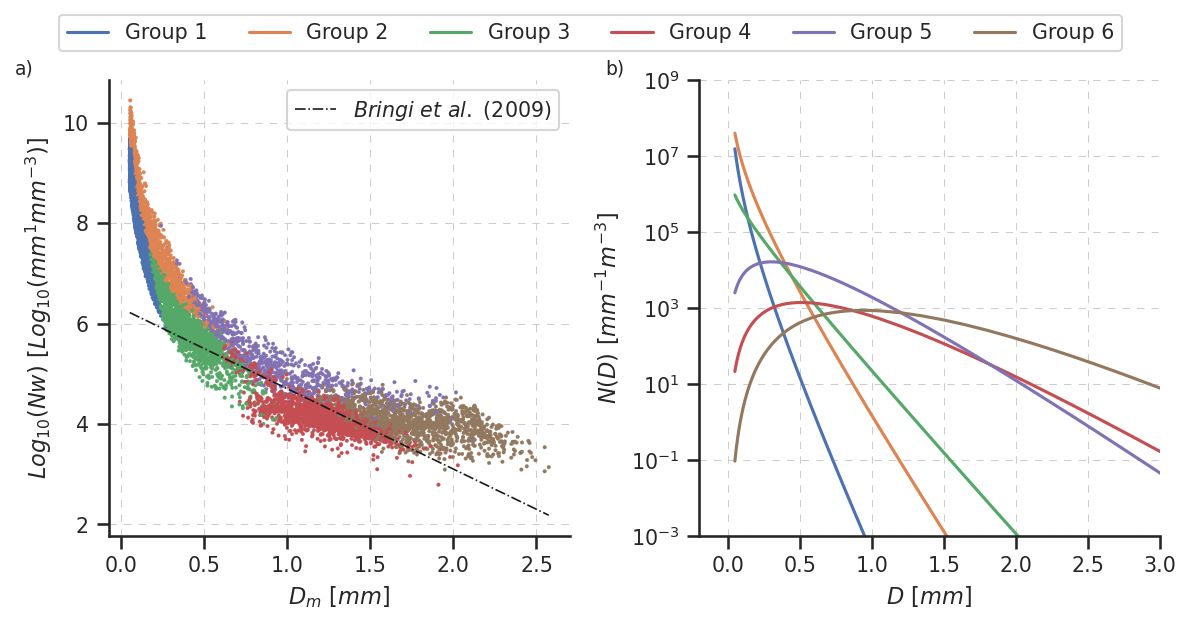

In [25]:
# Plotting results 
fig, axs = plt.subplot_mosaic([['a)', 'b)']], figsize=(8,4))

# left panel
ax = axs['a)']
# Scatter plot of Dm and Nw
ax = sns.scatterplot(data=df, x=df['dm'], y=df['log10_nw'], hue=df['kmeans'], s=3,
                     ax=ax,palette=sns.color_palette('deep', 6), 
                     legend=False, edgecolor=None)
# plt.setp(ax.collections, alpha=0.4)
ax.set_xlabel(r"$D_m \ [mm]$")
ax.set_ylabel(r"$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])

dms = np.linspace(df['dm'].min(), df['dm'].max(), 100)
d = dt_camp2ex['Lear'].ds.diameter/1000

# Plotting Bringi et al (2009) convective-stratiform separation
s_c = -1.6 * dms + 6.3
ax.plot(dms, s_c, c='k', ls='-.', lw=0.8, label=r"$Bringi \ et \ al. \ (2009)$")
ax.legend()

# right panel
ax1 = axs['b)']
ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e9)
ax1.grid('both')
ax1.set_ylabel(r"$N(D) \  [mm^{-1}m^{-3}]$")
ax1.set_xlabel(r"$D \ [mm]$")
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax1.set_xlim(-0.2, 3)

# computing the mean particle size distribution for each group
for i in range(1, n_c + 1):
    df_sub = df[df['kmeans'] == i]
    mu = df_sub['mu_unc'].quantile(0.5)
    # mu = df_sub['mu'].quantile(0.5)

    dm = df_sub['dm'].quantile(0.5)
    nw = (10 ** (df_sub['log10_nw'])).quantile(0.5)
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(d, gm, c=colors6[i-1], label=f"Group {i}")


lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]


fig.legend(lines[1:], labels[1:], loc='upper center', ncol=6, bbox_to_anchor=[0.5, 1.05])
for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(-45/72, -1/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.05, label, transform=ax.transAxes + trans,
            fontsize='small', verticalalignment='top')
fig.tight_layout()
sns.despine()
plt.savefig('../images/kmeans_scatter.svg',  bbox_inches='tight')

## Dataset Imbalance

It is safe to check data imbalance before performing a machine learning algorithm. We set a $1 mm$ treshold in $D_m$ for counting the number of PSDs within each category. 

In [26]:
# creating a categorical variable to split data into greater and smaller Dm
df['dm_class'] = (df.dm >= 1.0).astype(int)

Then, we can create a two-dimension histogram to see the density distribution of our dataset. Also, we can include a bar diagram with the two classess we previously defined ($D_m >= 1mm$ and $D_m < 1mm$)

Let's compute the 2D-histogram inputs

In [27]:
xbins = np.linspace(ds.dm.min(), ds.dm.max(), 50)
ybins = np.linspace(ds.log10_nw.min(), ds.log10_nw.max(), 50)
psd = histogram(ds.dm, ds.log10_nw, bins=[xbins, ybins])

Now, we can plot a scatter plot for $D_m$ and $N_w$ and visualize the data imbalance results

Text(0.5, 1.0, 'Counts')

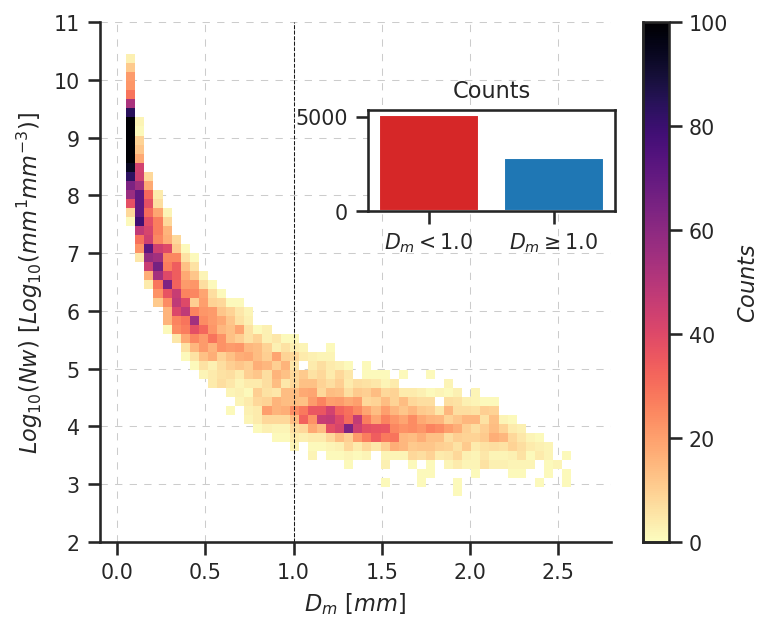

In [28]:
fig, ax = plt.subplots(figsize=(5.5,4.5))

# 2D-histogram
im = psd.T.where(psd.T > 0, np.nan).plot(add_colorbar=False, ax=ax, cmap='magma_r', vmin=0, vmax=100)
fig.colorbar(im , ax=ax, label=r"$Counts$")
ax.set_xlabel(r"$D_m \ [mm]$")
ax.set_ylabel(r"$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
sns.despine()
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax.set_xlim(-0.1, 2.8)
ax.set_ylim(2, 11)
ax.vlines(x=1, ymin=2, ymax=11, lw=0.5, linestyle='--', color='k')

# Bar plot
l, b, h, w = .45, .60, .15, .3
ax2 = fig.add_axes([l, b, w, h])
bar_colors = ['tab:red', 'tab:blue']
ax2.bar([r'$D_m < 1.0$', r"$D_m \geq 1.0$"], np.bincount(df['dm_class']), color=bar_colors)
ax2.set_title("Counts")

## Median values for the key parameters

We can compute the median value for the key parameters including $D_m$, $N_w$, $μ_{unc}$, $σ$,$R$, $N_t$ and $v$ for each PSD family identified using the clustering technique. (Table 1. presented in the paper)

In [29]:
df[['kmeans', 'dm','log10_nw', 'mu_unc', 'sigma', 'r', 'lognt', 'vert_vel']].groupby('kmeans').median()

,dm,log10_nw,mu_unc,sigma,r,lognt,vert_vel
kmeans,,,,,,,
1,0.083064,8.338401,-2.522908,0.060850,0.196701,6.104998,-0.1
2,0.183333,7.774711,-1.669490,0.147636,2.442079,6.634116,0.1
3,0.364595,5.975956,-0.537198,0.169559,1.205937,5.490301,-0.1
4,1.214712,4.110796,2.925983,0.341281,5.759596,2.767156,-0.1
5,0.929985,5.061843,1.938368,0.603650,13.631676,6.136225,0.5
6,1.764347,4.011642,4.587313,0.574585,24.252981,2.954027,-0.3


## Violin plots for vertical velocity and Altitude

In [37]:
df_up=df[['vert_vel','kmeans']].copy().reset_index()
df_down=df[['vert_vel','kmeans']].copy().reset_index()

# Compute the running maximum over 5 points
df_up['extreme'] = df['vert_vel'].rolling(window=10).max()

# Compute the running minimum over 5 points
df_down['extreme'] = df['vert_vel'].rolling(window=10).min()

df_up['updn'] = "Max Updraft"
df_down['updn']  = "Max Downdraft"

df_plot= pd.concat([df_up, df_down], axis=0).reset_index()

/tmp/ipykernel_20634/4048623781.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  alt = sns.violinplot(data=df, x='kmeans', y='altitude',palette=sns.color_palette('deep', 6),


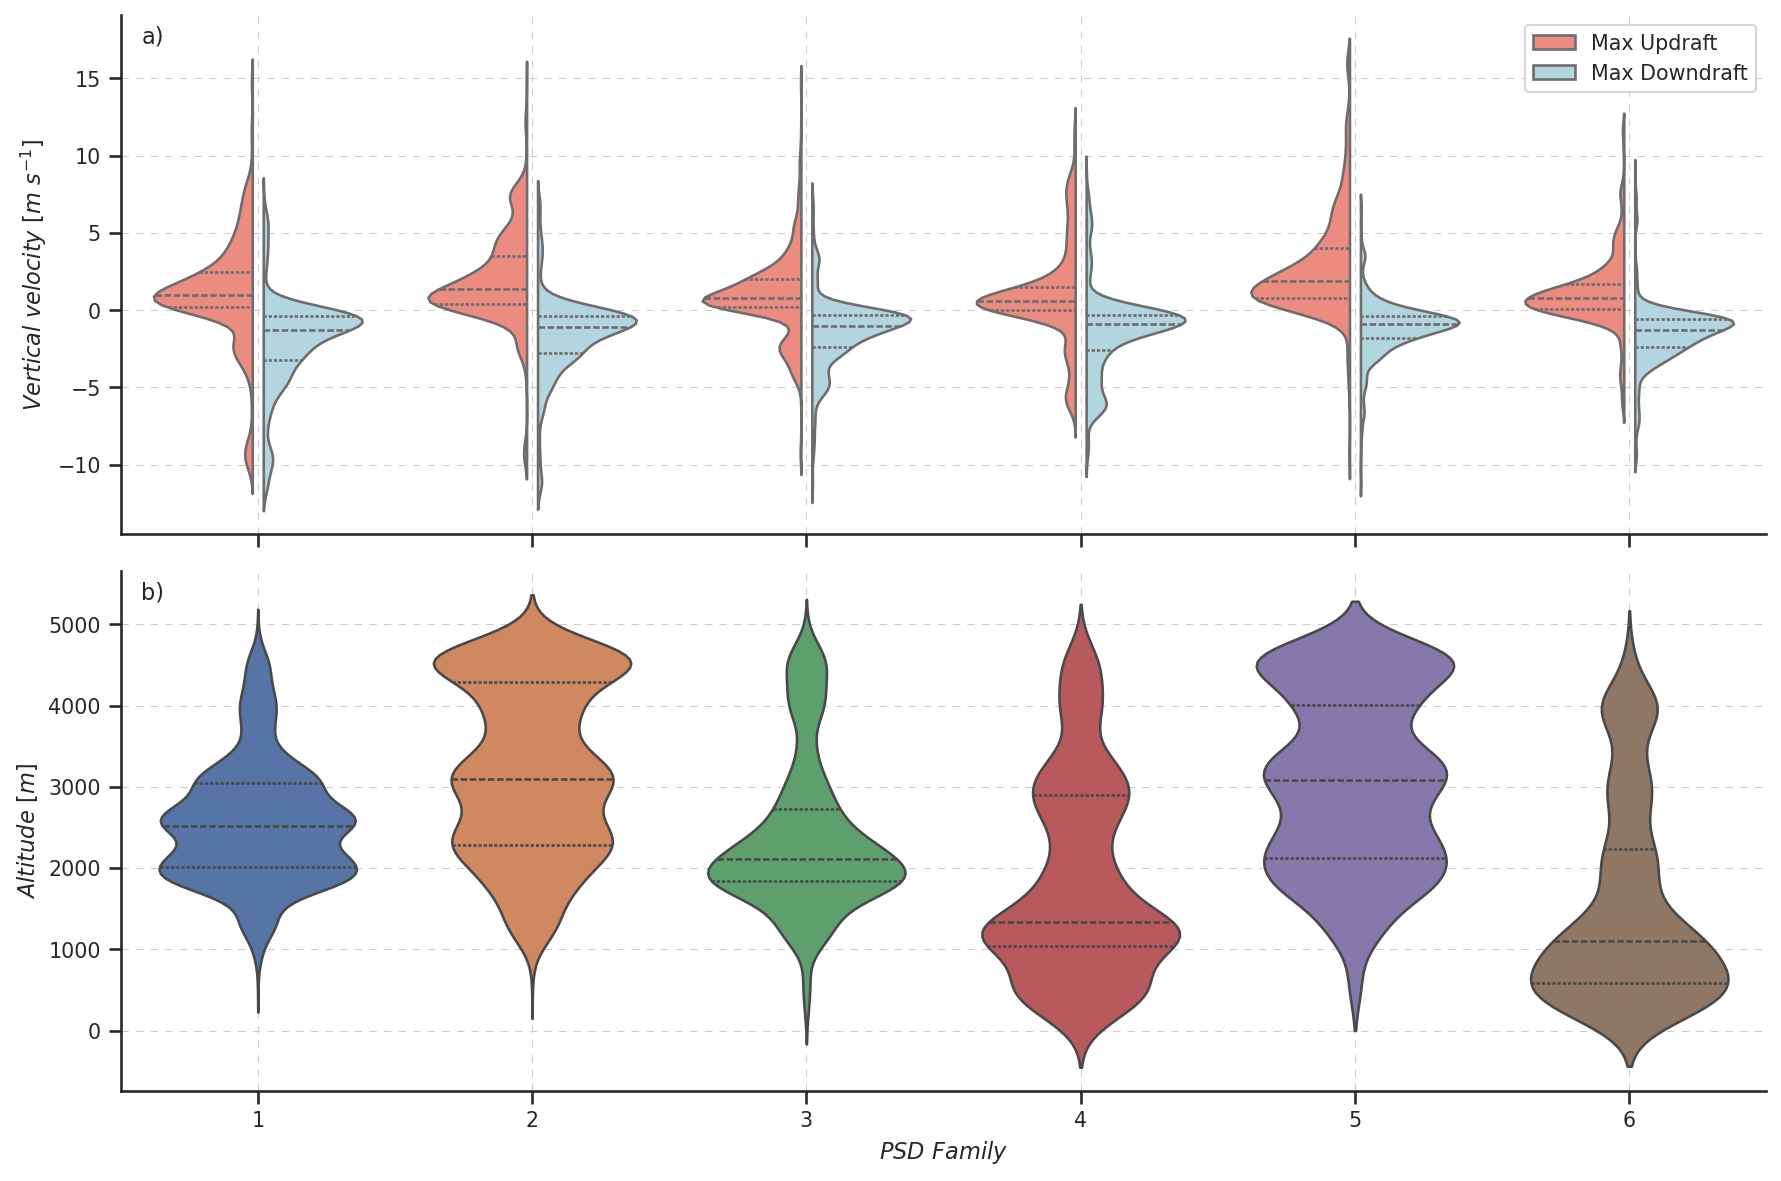

In [44]:
# Plotting results 
fig, axs = plt.subplot_mosaic([['a)'], ['b)']], figsize=(12,8), sharex=True)
ax = axs['a)']
# Draw a nested violinplot and split the violins for easier comparison
w = sns.violinplot(data=df_plot, x="kmeans", y="extreme", hue="updn",
               palette=["salmon","lightblue"], saturation=0.8,
                   ax=ax, gap=.1, inner="quart", density_norm='width', legend='brief', 
                   split=True)
w.legend_.set_title(None)
# w = sns.violinplot(data=df, x='kmeans', y='vert_vel', palette=sns.color_palette('deep', 6),
#                    saturation=0.8,
#                    ax=ax, gap=.1, inner="quart", density_norm='width', 
#                    legend=True,
#                    )
ax.set_ylabel(r"$Vertical \ velocity \ [m\  s^{-1}]$")
ax1 = axs['b)']

alt = sns.violinplot(data=df, x='kmeans', y='altitude',palette=sns.color_palette('deep', 6),
                    saturation=0.8,
                   ax=ax1, gap=.1, inner="quart", density_norm='width', 
                   legend=True,
                   )
ax1.set_ylabel(r"$Altitude \ [m]$")
ax1.set_xlabel(r"$PSD \ Family$")
sns.despine()
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
fig.tight_layout()
for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top')

plt.savefig('../images/violin_vel_alt.svg',  bbox_inches='tight')

In [31]:
df['epsilon'] = (df["r"] / (1.370 * df['dm'] ** 5.420)) ** (1 / 4.258)

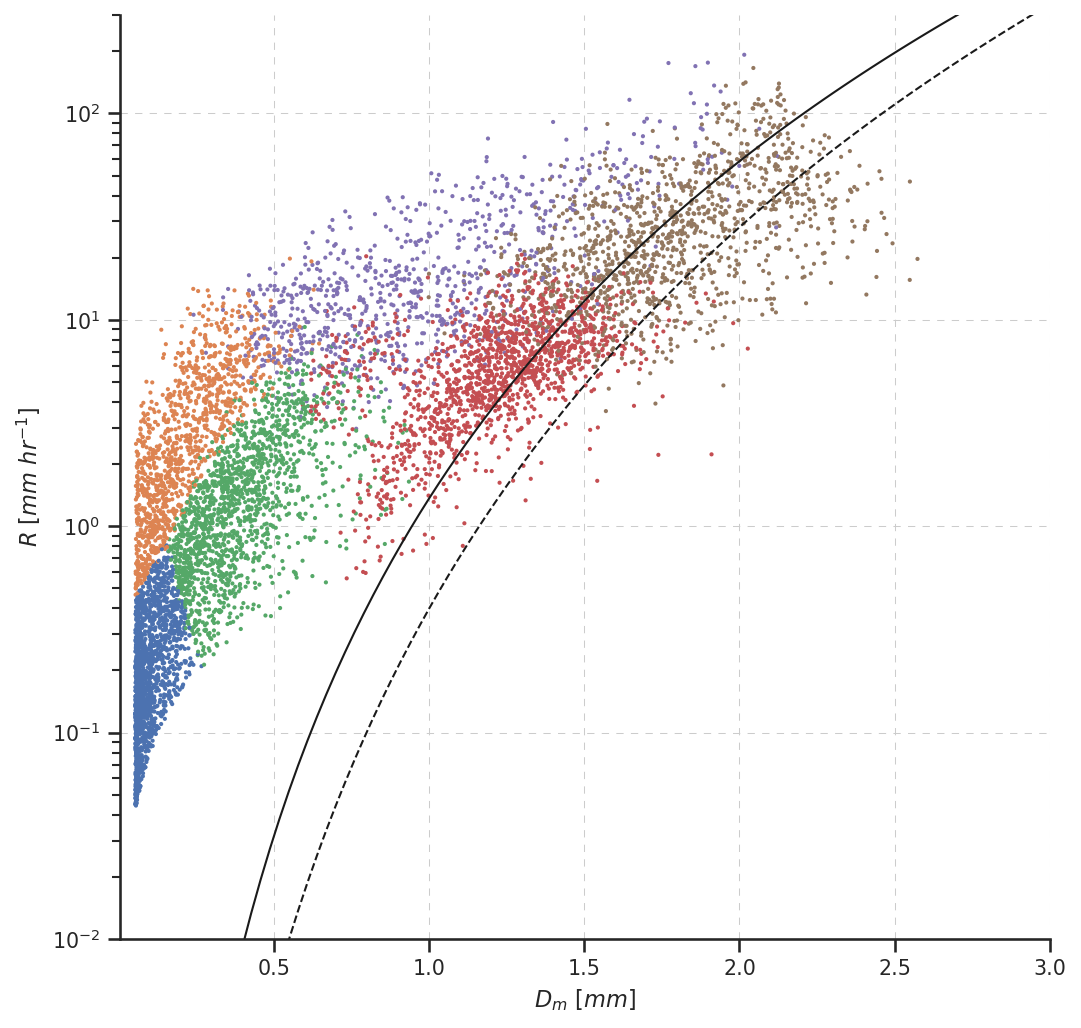

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
grp = df
ax.scatter(x=grp['dm'], y=grp['r'], s=1, c=df['kmeans'], cmap=my_cmap6)
ax.plot(dm, conv(dm), lw=1, c='k')
ax.plot(dm, strat(dm), lw=1, c='k', ls="--")
ax.set_yscale('log')
ax.set_ylim(0.01, 300)
ax.set_xlim(0.001, 3)
ax.set_ylabel(r"$R \ [mm \ hr^{-1}]$")
ax.set_xlabel(r"$D_m \ [mm]$")
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
sns.despine()
plt.savefig('../images/r_dm_gpm_ope.svg',  bbox_inches='tight')

### Saving dataframe

We saved the Kmeans output and dataset imbalance results for further analysis

In [36]:
df.to_parquet('../data/df_cluster.parquet')